Tokenizing
Removing duplicates based on 'ids'
Tokenizing
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'tfidf__ngram_range': (1, 1), 'tfidf__min_df': 1, 'tfidf__max_features': 10000, 'tfidf__max_df': 0.2, 'classifier__C': 0.1}
F1 Score on training set: 0.8228
F1 Score on test set: 0.7987
Difference between training and test F1 Score: 0.0241


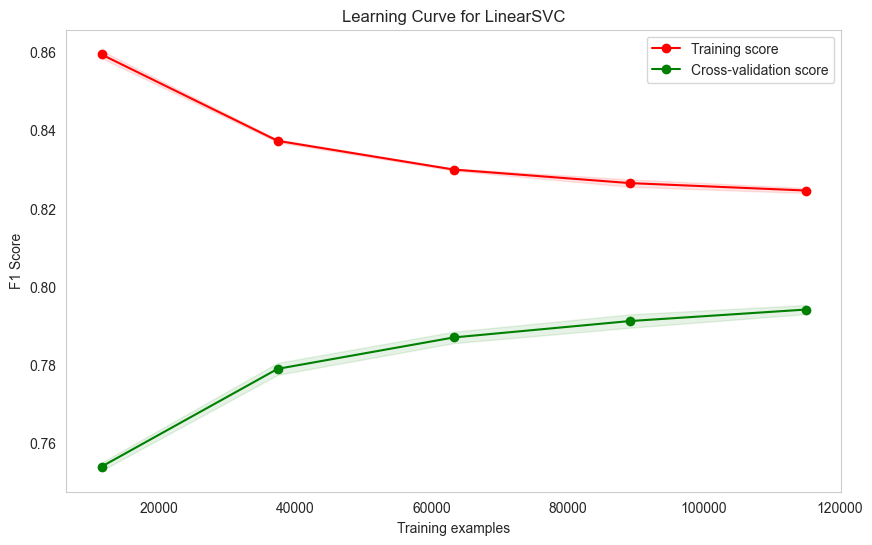

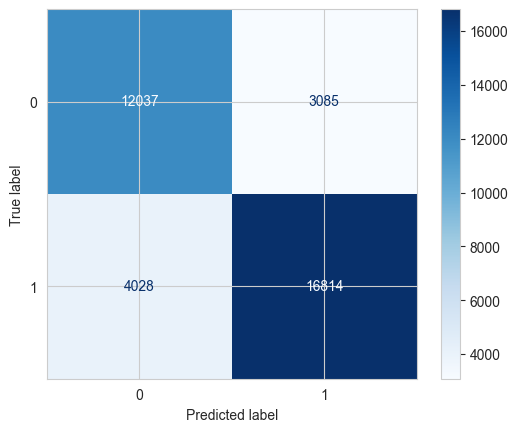

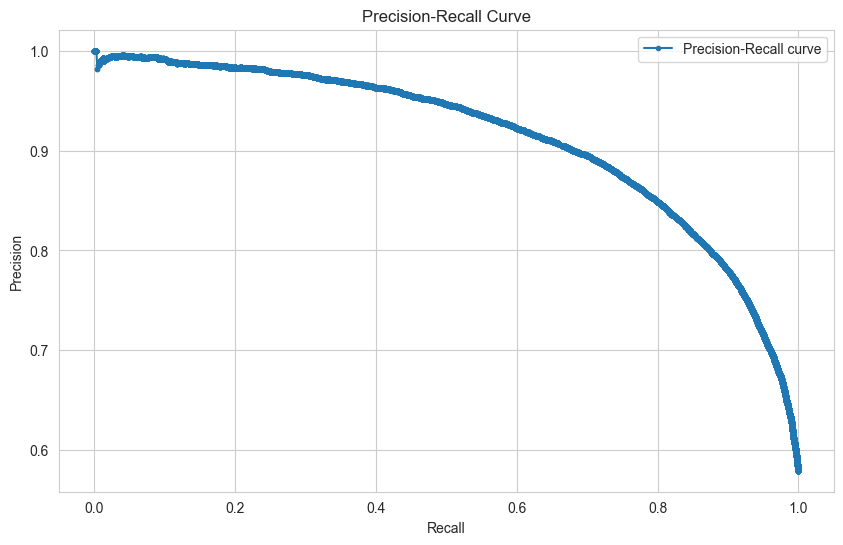

<Figure size 1200x600 with 0 Axes>

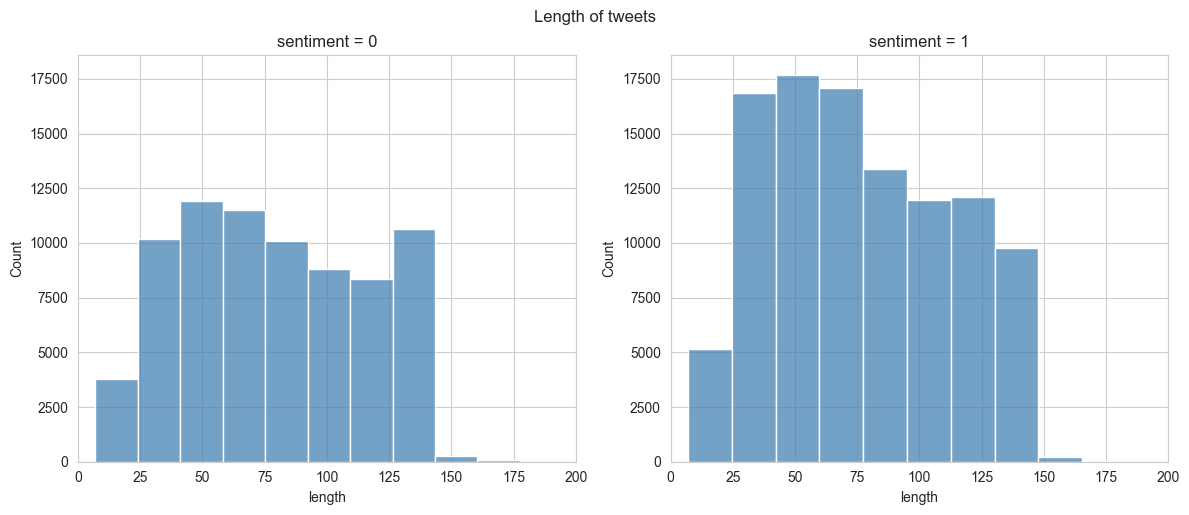

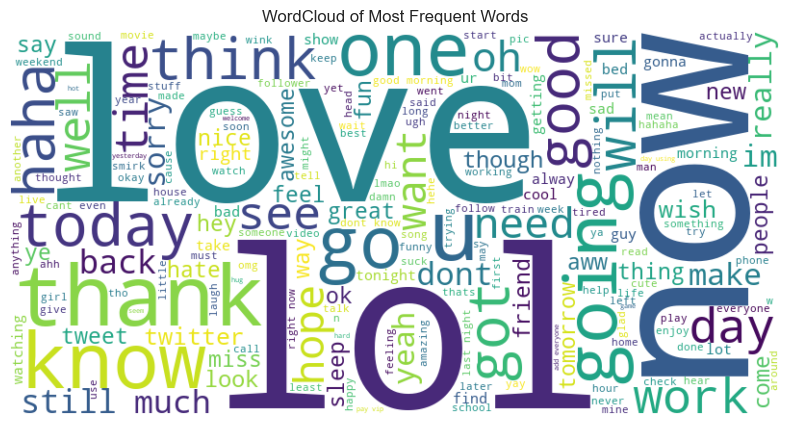

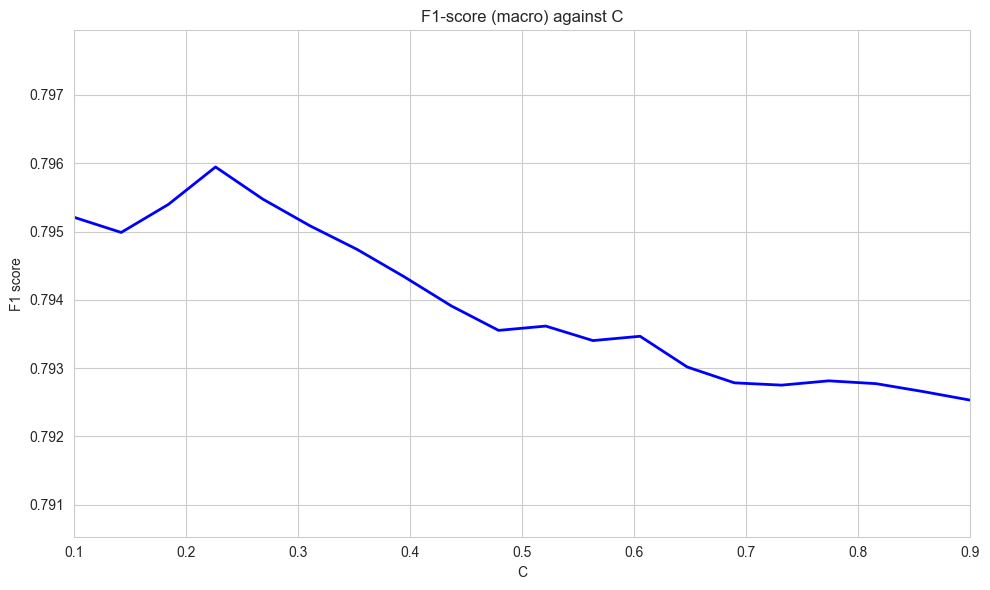

Optimal C value: 0.23
Maximum F1 Score on test set: 0.7959
Submission file created: submission.csv


In [ ]:
# Importare le librerie necessarie
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from nltk.tokenize import TweetTokenizer
from scipy.sparse import hstack

# Funzione per preprocessare il dataframe
def preprocess_dataframe(df, ohe_date=None):
    # Rimuovere la colonna 'flag' dal dataset
    df_preprocessed = df.drop(columns=['flag'])

    # Dizionario per la sostituzione di caratteri speciali
    substitutions = {
        '&quot;': '"',
        '&amp;': '&',
        '&gt;': '>',
        '&lt;': '<',
        '<3': 'love'
    }

    # Emoticon da sostituire con descrizioni testuali (codice openSource)
    EMOTICONS_EMO = {
    ':‑)': 'Happy face or smiley',
    ':)': 'Happy face or smiley',
    ':))': 'Very Happy face or smiley',
    ':)))': 'Very very Happy face or smiley',
    ':]': 'Happy face or smiley',
    ':3': 'Happy face smiley',
    ':->': 'Happy face smiley',
    ':>': 'Happy face smiley',
    ':o)': 'Happy face smiley',
    ':}': 'Happy face smiley',
    ':c)': 'Happy face smiley',
    ':^)': 'Happy face smiley',
    '=]': 'Happy face smiley',
    '=)': 'Happy face smiley',
    ':‑D': 'Laughing, big grin or laugh with glasses',
    ':D': 'Laughing, big grin or laugh with glasses',
    '8‑D': 'Laughing, big grin or laugh with glasses',
    '8D': 'Laughing, big grin or laugh with glasses',
    'X‑D': 'Laughing, big grin or laugh with glasses',
    'XD': 'Laughing, big grin or laugh with glasses',
    '=D': 'Laughing, big grin or laugh with glasses',
    '=3': 'Laughing, big grin or laugh with glasses',
    ':‑(': 'Frown, sad, andry or pouting',
    ':(': 'Frown, sad, andry or pouting',
    ':‑c': 'Frown, sad, andry or pouting',
    ':c': 'Frown, sad, andry or pouting',
    ':‑<': 'Frown, sad, andry or pouting',
    ':<': 'Frown, sad, andry or pouting',
    ':‑[': 'Frown, sad, andry or pouting',
    ':[': 'Frown, sad, andry or pouting',
    ":'‑(": 'Crying',
    ":'(": 'Crying',
    ":'‑)": 'Tears of happiness',
    ":')": 'Tears of happiness',
    ':‑O': 'Surprise',
    ':O': 'Surprise',
    ':‑o': 'Surprise',
    ':o': 'Surprise',
    ';‑)': 'Wink or smirk',
    ';)': 'Wink or smirk',
    ':P': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':‑Þ': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':Þ': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':b': 'Tongue sticking out, cheeky, playful or blowing a raspberry',
    ':‑|': 'Straight face',
    ':|': 'Straight face',
    ':$': 'Embarrassed or blushing',
    ':L': 'Skeptical, annoyed, undecided',
    ':S': 'Skeptical, confused'
    }

    # Applicare le sostituzioni
    for abbr, full_form in substitutions.items():
        df_preprocessed['text'] = df_preprocessed['text'].str.replace(abbr, full_form, regex=False)

    # Applicare la sostituzione degli emoticon
    for emoticon, description in EMOTICONS_EMO.items():
        df_preprocessed['text'] = df_preprocessed['text'].str.replace(emoticon, description, regex=False)

    # Calcolo della lunghezza del tweet
    tweet_length = df_preprocessed['text'].str.len()

    # Rimozione dei link
    link_regex = r'(?:www\.|https?://)\S+'
    contains_links = df_preprocessed['text'].apply(lambda x: bool(re.search(link_regex, x)))
    df_preprocessed['text'] = df_preprocessed['text'].apply(lambda x: re.sub(link_regex, '', x))

    # Rimozione degli hashtag
    hashtag_regex = r'#\w+'
    df_preprocessed['text'] = df_preprocessed['text'].str.replace(hashtag_regex, '', regex=True)

    # Conteggio delle menzioni
    mention_regex = r'@\w+'
    contains_mentions = df_preprocessed['text'].str.contains(mention_regex)

    # Rimozione delle menzioni
    df_preprocessed['text'] = df_preprocessed['text'].str.replace(mention_regex, '', regex=True)

    # Tokenizzazione del testo
    print("Tokenizing...")
    tokenized_tweets = []
    tokenizer = TweetTokenizer()
    for tweet in df_preprocessed['text']:
        tokens = tokenizer.tokenize(tweet)
        filtered_tweet = []
        for word in tokens:
            word = re.sub(r'((.)\2)\2+', r'\1', word.strip().lower())
            if word.isalnum() or "'" in word:
                if word == "don't":
                    word = 'dont'
                filtered_tweet.append(word)
        tokenized_tweets.append(filtered_tweet)

    # Combinare il testo tokenizzato con il nome utente
    df_preprocessed['filtered_text'] = [" ".join(map(str, l)) for l in tokenized_tweets]
    df_preprocessed['filtered_text'] = df_preprocessed['filtered_text'] + " " + df['user']

    # Parsing delle date
    df_preprocessed['day'] = [date[0] for date in df_preprocessed['date'].str.split()]
    df_preprocessed['date-month'] = [date[1] + " " + date[2] for date in df_preprocessed['date'].str.split()]
    df_preprocessed['hour'] = [int(date[3].split(':')[0]) for date in df_preprocessed['date'].str.split()]

    # Codifica delle date con OneHotEncoder
    if ohe_date is None:
        ohe_date = OneHotEncoder(sparse_output=False, dtype=int)
        day_month = ohe_date.fit_transform(df_preprocessed[['day', 'date-month']])
    else:
        day_month = ohe_date.transform(df_preprocessed[['day', 'date-month']])

    df_preprocessed = df_preprocessed.drop(columns=['day', 'date-month', 'date'])
    df_preprocessed = pd.concat([df_preprocessed, pd.DataFrame(day_month)], axis=1)

    # Aggiungere le nuove feature
    df_preprocessed['length'] = tweet_length
    df_preprocessed['contains_links'] = list(map(int, contains_links))
    df_preprocessed['contains_mentions'] = list(map(int, contains_mentions))

    return df_preprocessed, ohe_date

# Funzione per tracciare la learning curve
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(.1, 1.0, 5),
        scoring='f1_macro'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Funzione per tracciare la matrice di confusione
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# Funzione per tracciare il grafico Precision-Recall
def plot_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

# Funzione per tracciare la distribuzione della lunghezza dei tweet
def plot_tweet_length_by_sentiment(df_preprocessed):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot per sentiment 0
    sns.histplot(data=df_preprocessed[df_preprocessed['sentiment'] == 0],
                 x='length', bins=20, kde=False, color='steelblue', ax=ax1)
    ax1.set_title("sentiment = 0")
    ax1.set_xlabel("length")
    ax1.set_ylabel("Count")

    # Plot per sentiment 1
    sns.histplot(data=df_preprocessed[df_preprocessed['sentiment'] == 1],
                 x='length', bins=20, kde=False, color='steelblue', ax=ax2)
    ax2.set_title("sentiment = 1")
    ax2.set_xlabel("length")
    ax2.set_ylabel("Count")

    max_count = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    ax1.set_ylim(0, max_count)
    ax2.set_ylim(0, max_count)
    ax1.set_xlim(0, 200)
    ax2.set_xlim(0, 200)
    plt.tight_layout()
    plt.suptitle("Length of tweets", y=1.02)
    plt.show()


# Funzione per generare un WordCloud
def plot_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud of Most Frequent Words")
    plt.show()


# Funzione per tracciare il grafico F1 score al variare del parametro C
def plot_f1_vs_C(pipeline, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Range di valori C
    C_values = np.linspace(0.1, 0.9, 20)  # 20 punti da 0.1 a 0.9
    f1_scores = []

    for C in C_values:
        pipeline.set_params(classifier__C=C)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        f1_scores.append(f1)

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    plt.plot(C_values, f1_scores, color='blue', linewidth=2)
    plt.xlabel('C')
    plt.ylabel('F1 score')
    plt.title('F1-score (macro) against C')
    plt.xlim(0.1, 0.9)
    plt.ylim(min(f1_scores) - 0.002, max(f1_scores) + 0.002)
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
    plt.tight_layout()
    plt.show()

    # Trova e stampa il C ottimale
    max_f1 = max(f1_scores)
    optimal_C = C_values[f1_scores.index(max_f1)]
    print(f"Optimal C value: {optimal_C:.2f}")
    print(f"Maximum F1 Score on test set: {max_f1:.4f}")

# Caricare i dati di sviluppo
df_dev = pd.read_csv('development.csv')
df_preprocessed, ohe_date = preprocess_dataframe(df_dev)

# Rimuovere duplicati basati su 'ids'
print("Removing duplicates based on 'ids'")
df_preprocessed = df_preprocessed.drop_duplicates(subset=['ids'], keep='first')

# Creazione del set finale
X = df_preprocessed[['filtered_text']]
y = df_preprocessed['sentiment']

# Caricare i dati di valutazione
df_eval = pd.read_csv('evaluation.csv')
df_eval_preprocessed, _ = preprocess_dataframe(df_eval, ohe_date)

# Pipeline automatizzata
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorizzazione dei tweet
    ('classifier', LinearSVC(class_weight='balanced', max_iter=10000, dual=False))  # Classificatore SVM
])

# Hyperparameter tuning con RandomizedSearchCV
param_distributions = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Ridurre l'overfitting -> Evitare ngram grandi
    'tfidf__max_df': [0.1, 0.2, 0.5],  # Ridurre max_df -> Rimuove parole troppo frequenti
    'tfidf__min_df': [1, 5, 10],  # Ridurre min_df -> Aggiunge parole rilevanti
    'tfidf__max_features': [1000, 5000, 10000], # provare a dare più valori 5000, 10000, 15000
    'classifier__C': np.logspace(-3, 0, 10),  # Valori bassi di C -> Maggiore regolazione
}

# Cross-validation stratificata
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=30,  # Numero di iterazioni di ricerca casuale
    scoring='f1_macro',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Suddividere i dati in train e test set
X_train, X_test, y_train, y_test = train_test_split(X['filtered_text'], y, test_size=0.2, stratify=y, random_state=42)

# Ricerca dei parametri ottimali
random_search.fit(X_train, y_train)

# Stampa dei migliori parametri trovati
print("Best parameters:", random_search.best_params_)
# print("Best F1 score on training data:", random_search.best_score_)

# Valutazione sui dati di training
y_pred_train = random_search.best_estimator_.predict(X_train)
train_f1 = f1_score(y_train, y_pred_train, average='macro')
print(f"F1 Score on training set: {train_f1:.4f}")

# Valutazione sui dati di test
y_pred_test = random_search.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, y_pred_test, average='macro')
print(f"F1 Score on test set: {test_f1:.4f}")

# Confronto F1 score tra training e test -> Verifica dell'overfitting con scarto basso
print(f"Difference between training and test F1 Score: {train_f1 - test_f1:.4f}")

# Tracciare la learning curve
plot_learning_curve(random_search.best_estimator_, X_train, y_train, "Learning Curve for LinearSVC")

# Tracciare la matrice di confusione
plot_confusion_matrix(y_test, y_pred_test, classes=np.unique(y_test))

# Precision-Recall Curve
plot_precision_recall(y_test, random_search.best_estimator_.decision_function(X_test))

# Distribuzione della lunghezza dei tweet in base al sentiment
plot_tweet_length_by_sentiment(df_preprocessed)

# Generare il WordCloud
all_text = " ".join(df_preprocessed['filtered_text'])
plot_wordcloud(all_text)

# F1 Score al variare della variabile C
plot_f1_vs_C(random_search.best_estimator_, X_train, y_train)

# Predizioni sui dati di valutazione
X_eval_vectorized = df_eval_preprocessed['filtered_text']
y_pred_eval = random_search.best_estimator_.predict(X_eval_vectorized)

# Preparare il file di sottomissione
submission = pd.DataFrame({
    'Id': df_eval['ids'],
    'Predicted': y_pred_eval
})

submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")
